# Molecular Dynamics Simulations

## Overview

### Questions

* In a rigid body molecular dynamics simulation, how are thermodynamic quantities measured?  

### Objectives

* Define how quanties like the energy are defined in a rigid body molecular dynamics simulation. 
* Run a rigid body MD simulation at constant temperature.
* Show that thermodynamic quantities (the total translational kinetic energy in our example) are defined in reference to the mass of the rigid bodies not the constituent particles of the rigid body.

In [1]:
import itertools
import math
import gsd.hoomd
import hoomd
import numpy
import rowan
from hoomd.md import constrain

## Thermodynamic Quantities in MD Simulations

The thermodynamic quantities in simulations of rigid bodies are conducted under the assumption that the center of mass of the rigid bodies and free particles is the only information in the simuation that the computation of the thermodynamic quantities is taken from.

This means that the constituent particles contribute only to the forces between rigid body and free particles but not to the calculation of temperature or energy in the simulation.

We will demonstrate this below by showing that the translational kinetic energy of the system is equal to the translational kinetic energy of the rigid bodies.

First we initialize a simulation like the one we conducted in initializing a rigid body simulation.

The `render_simulation` function in the next (hidden) cell will render the system state using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel
import IPython

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render_simulation(radius_constituent,snapshot):
    '''
    Outputs sphere positions based on the trajectory of the simulation
    '''
    wh_sp = numpy.where((snapshot.particles.typeid == 1))
    pos_parts = snapshot.particles.position[wh_sp]
    L = snapshot.configuration.box[0]
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(pos_parts),
                                       radius=radius_constituent)
    geometry.position[:] = pos_parts
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)
    
    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
Mass_Rigid_body = 2.
Inertia_Tensor = numpy.array([[24/5,0,0],[0,14/5,0],[0,0,14/5]])
local_position = [[1,0,0],[-1,0,0]]

m = 2
N_particles = 2 * m**3
spacing = 10.
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = numpy.array(position)
position[:,0] = position[:,0]
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position[0:N_particles,:]
snapshot.particles.orientation = [(1,0,0,0)] * N_particles
snapshot.particles.typeid = [0] * N_particles
snapshot.configuration.box = [L, L, L, 0, 0, 0]
snapshot.particles.mass = [Mass_Rigid_body] * N_particles
snapshot.particles.types = ['rigid_body','constituent_sphere']
snapshot.particles.moment_inertia = [(Inertia_Tensor[0,0],Inertia_Tensor[1,1],Inertia_Tensor[2,2])] * N_particles
snapshot.particles.angmom = [(1,1,1,1)] * N_particles
with gsd.hoomd.open(name='lattice_rigid.gsd', mode='wb') as f:
    f.append(snapshot)

temperature = 1.

cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)
sim.create_state_from_gsd(filename='lattice_rigid.gsd')

epsilon = 1
sigma = 2/2**(1/6)
integrator = hoomd.md.Integrator(dt=0.0001,integrate_rotational_dof=True)
cell = hoomd.md.nlist.Cell(buffer=0,exclusions = ['body'])
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('rigid_body', 'rigid_body')] = dict(epsilon=0, sigma=sigma)
lj.params[('rigid_body', 'constituent_sphere')] = dict(epsilon=0, sigma=sigma)
lj.params[('constituent_sphere', 'constituent_sphere')] = dict(epsilon=epsilon, sigma=sigma)
lj.r_cut[('constituent_sphere', 'constituent_sphere')] = 4 * sigma 
lj.r_cut[('rigid_body', 'rigid_body')] = 0.
lj.r_cut[('rigid_body', 'constituent_sphere')] = 0.
integrator.forces.append(lj)

rigid_centers_and_free_filter = hoomd.filter.Rigid(("center", "free"))
nvt = hoomd.md.methods.NVT(kT = temperature, tau = 1., filter = rigid_centers_and_free_filter)
integrator.methods.append(nvt)

rigid = constrain.Rigid()
constituent_types = ['constituent_sphere','constituent_sphere']
rigid.body['rigid_body'] = {
    "constituent_types": constituent_types,
    "positions":local_position,
    "orientations":[(1,0,0,0)] * len(constituent_types),
    "charges":[0.] * len(constituent_types),
    "diameters":[2.] * len(constituent_types)}

In [4]:
rigid.create_bodies(sim.state)
integrator.rigid = rigid
sim.operations.integrator = integrator

In [5]:
# Gsd writer for simulations
logger = hoomd.logging.Logger(['particle','constraint'])
gsd_oper = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(1000), filename='randomization.gsd',log=logger,mode='wb',dynamic=['momentum','property'])
sim.operations += gsd_oper

## We now want to compute the thermodynamic properties:

For this example we want to compare the system wide translational kinetic energy calculated by hoomd matches to the translational kinetic energy calculated from the velocities and masses of the rigid bodies. 

We will thereby demonstrate the the thermodynamic quantities of the system are determined by the properties of the rigid bodies (mass, moment of inertia, ect.), and the forces between the constituent particles but the masses of the constituent particles. The constituent particles only define the force field between rigid bodies. 

In [6]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=rigid_centers_and_free_filter)

sim.operations.computes.append(thermodynamic_properties)
sim.state.thermalize_particle_momenta(filter=rigid_centers_and_free_filter, kT=temperature)

## We now run the simulation

In [7]:
sim.run(20000)

In [8]:
thermodynamic_properties.translational_kinetic_energy

29.72147704174968

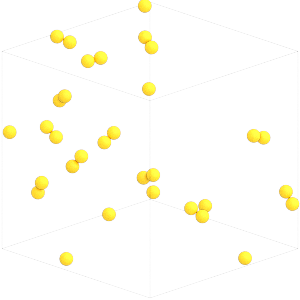

In [9]:
snapshot = gsd.hoomd.open('randomization.gsd')[-1]
render_simulation(1.,snapshot)

In [10]:
# Get the mass and velocity of the rigid bodies
rigid_body = numpy.where(snapshot.particles.typeid == 0)
velocity = snapshot.particles.velocity[rigid_body]
mass = snapshot.particles.mass[rigid_body]

print('translational kinetic energy calculated from velocity and mass of rigid bodies', numpy.sum(.5 * mass * numpy.linalg.norm(velocity,axis=1) * numpy.linalg.norm(velocity,axis=1)))

translational kinetic energy calculated from velocity and mass of rigid bodies 29.721481


Note that the translational kinetic energy for the rigid bodies is the same as the tranlational kinetic energy calculated for the simulation. 